In [2]:
import sys

import matplotlib.pyplot as plt
# Importing Image module from PIL package 
from PIL import Image 
import PIL 
import json

import torch
import torchvision
import torchvision.transforms as T
import models.convnext as convnext
from utils import NativeScalerWithGradNormCount as NativeScaler
import utils

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.5.4 

from timm import create_model

In [3]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)


device =  cuda


In [4]:
# Define transforms for test
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 384

# Here we resize smaller edge to 256, no center cropping
if SIZE ==384:
    transforms = [
              T.Resize(SIZE, interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

    transforms = T.Compose(transforms)
    print("transforms = ", transforms)
if SIZE == 244:
    transforms = [
              T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
              T.CenterCrop(SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

    transforms = T.Compose(transforms)
    print("transforms = ", transforms)

transforms =  Compose(
    Resize(size=384, interpolation=bicubic)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [5]:
print(SIZE)

384


In [6]:
SIZE=384
if SIZE==224:
    checkpoint = torch.load('/home/pms/ConvNeXt/model_ckpt_244_300/checkpoint-best.pth', map_location='cpu')
if SIZE==384:
    checkpoint = torch.load('/home/pms/ConvNeXt/model_ckpt_384_400/checkpoint-best.pth', map_location='cpu')

In [7]:
model = create_model(
        'convnext_tiny', 
        pretrained=False, 
        num_classes=10, 
        drop_path_rate=0,
        layer_scale_init_value=1e-6,
        head_init_scale=1.0,
        )

utils.load_state_dict(model, checkpoint['model'])
args = checkpoint['args']

print(args)
model.to(device)




Namespace(aa='rand-m9-mstd0.5-inc1', auto_resume=True, batch_size=16, clip_grad=None, color_jitter=0.4, crop_pct=None, cutmix=0.0, cutmix_minmax=None, data_path='../CIFAR-10-images/train', data_set='image_folder', device='cuda', disable_eval=False, dist_eval=True, dist_on_itp=False, dist_url='env://', distributed=False, drop_path=0, enable_wandb=True, epochs=400, eval=False, eval_data_path='../CIFAR-10-images/test', finetune='checkpoint-best.pth', head_init_scale=1.0, imagenet_default_mean_and_std=True, input_size=384, layer_decay=1.0, layer_scale_init_value=1e-06, local_rank=-1, log_dir=None, lr=0.0004, min_lr=1e-06, mixup=0.0, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='convnext_tiny', model_ema=False, model_ema_decay=0.9999, model_ema_eval=False, model_ema_force_cpu=False, model_key='model|module', model_prefix='', momentum=0.9, nb_classes=10, num_workers=8, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='model_ckpt', pin_mem=True, project='convnext', r

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU()
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


9 43.32%
1 41.99%
4 3.16%
5 2.20%
6 1.76%
7 1.73%
3 1.62%
2 1.50%
0 1.45%
8 1.27%


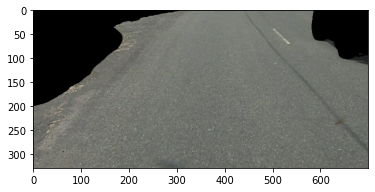

In [8]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
img = PIL.Image.open('test.jpg')
img_tensor = transforms(img).unsqueeze(0).to(device)

# inference
output = torch.softmax(model(img_tensor), dim=1)
top10 = torch.topk(output, k=10)
top10_prob = top10.values[0]
top10_indices = top10.indices[0]

for i in range(10):
    labels = str(int(top10_indices[i]))
    prob = "{:.2f}%".format(float(top10_prob[i])*100)
    print(labels, prob)

plt.imshow(img)


In [9]:
import pathlib
import os

class_names = ['1','10','2' ,'3' ,'4' ,'5' ,'6', '7' ,'8' ,'9']
import xlwt
from xlwt import Workbook
  
# Workbook is created
wb = Workbook()
# add_sheet is used to create sheet.
test = wb.add_sheet('Test-road-Summary')
#test_data_dir= "/home/pms/CIFAR-10-images/test"
test_data_dir = pathlib.Path("/home/pms/pms-dataset/psci-10-roadsurvey/splitted-orig/val/cropImg")
output_test_dir = pathlib.Path("./results/iter3/convnext_tiny_test_cropImg")
model.eval()
try:
    os.makedirs(output_test_dir, exist_ok=True)
    print("Directory created")
except OSError as e:
    print("Directory already exists")
count = 0

count = 0
countf = 0
countF = 0
countT = 0
count_loop = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0
count7 = 0
count8 = 0
count9 = 0
count10 = 0
root, class_n, files = next(os.walk(test_data_dir))
print(class_n)
for c in class_n:
    new_root = os.path.join(output_test_dir, c)
    try:
        os.mkdir(new_root)
    except OSError as e:
        print("Directory already exists")
    for dirs in os.walk(os.path.join(root, c)):
        for files in dirs:
            for filename in files:
                if(filename.endswith(".jpg")):
                    path = os.path.join(root, c, filename)
                    #img = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
                    img = PIL.Image.open(path)
                    img_tensor = transforms(img).unsqueeze(0).to(device)
                    output = torch.softmax(model(img_tensor), dim=1)
                    top1 = torch.topk(output, k=1)
                    if (int(class_names[int(str(int(top1.indices[0])))])==int(c)):
                        count=count+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==10):
                        countf=countf+1
                        count10=count10+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==9):
                        countf=countf+1
                        count9=count9+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==8):
                        countf=countf+1
                        count8=count8+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==7):
                        countf=countf+1
                        count7=count7+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==6):
                        countf=countf+1
                        count6=count6+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==5):
                        countf=countf+1
                        count5=count5+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==4):
                        countf=countf+1
                        count4=count4+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==3):
                        countf=countf+1
                        count3=count3+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==2):
                        countf=countf+1
                        count2=count2+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==1):
                        countf=countf+1
                        count1=count1+1
                    else:
                        print('error')
                    new_filename = filename.split(".")[0]+ filename.split(".")[1] + "_" + "P_" + str(int(class_names[int(str(int(top1.indices[0])))])) + ".jpg"
                    new_path = os.path.join(new_root, new_filename)

                    ##  uncomment the following line to save the image
                    ##cv2.imwrite(new_path, orig)
                    #print(new_filename )
                    
    countT = countT + count
    countF = countF + countf
    print('=========================================================')
    print('class: ',c, 'Images: ',len(files), 'TP: ', count/len(files), 'FP: ',countf/len(files))
    #print('one : ',count1/len(files),'two: ',count2/len(files),'three: ',count3/len(files),'four: ',count4/len(files),'five: ',count5/len(files),'six: ',count6/len(files),'seven: ',count7/len(files),'eight: ',count8/len(files),'nine: ',count9/len(files),'ten: ',count10/len(files))
    print('one: ',count1,'two: ',count2,'three: ',count3,'four: ',count4,'five: ',count5,'six: ',count6,'seven: ',count7,'eight: ',count8,'nine: ',count9,'ten: ',count10)
    test.write(int(c), 1, count1)
    test.write(int(c), 2, count2)
    test.write(int(c), 3, count3)
    test.write(int(c), 4, count4)
    test.write(int(c), 5, count5)
    test.write(int(c), 6, count6)
    test.write(int(c), 7, count7)
    test.write(int(c), 8, count8)
    test.write(int(c), 9, count9)
    test.write(int(c), 10, count10)
    test.write(int(c), 11, count)
    test.write(int(c), 12, countf)

    count = 0
    countf = 0
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    count6 = 0
    count7 = 0
    count8 = 0
    count9 = 0
    count10 = 0
    count_loop = count_loop + 1
print('Total classes: ',count_loop,'Total TP: ', countT/(countT+countF), 'Total FP: ',countF)
test.write(11, 0, countT/(countT+countF))
test.write(11, 1, countF)
wb.save('summary-test.xls')


Directory created
['10', '6', '5', '7', '1', '4', '2', '8', '9', '3']
class:  10 Images:  206 TP:  0.9611650485436893 FP:  0.038834951456310676
one:  0 two:  0 three:  1 four:  1 five:  0 six:  1 seven:  1 eight:  1 nine:  3 ten:  0
class:  6 Images:  105 TP:  0.5047619047619047 FP:  0.49523809523809526
one:  0 two:  1 three:  3 four:  6 five:  17 six:  0 seven:  7 eight:  9 nine:  6 ten:  3
class:  5 Images:  179 TP:  0.6480446927374302 FP:  0.35195530726256985
one:  2 two:  2 three:  29 four:  7 five:  0 six:  7 seven:  10 eight:  0 nine:  1 ten:  5
class:  7 Images:  261 TP:  0.8122605363984674 FP:  0.18773946360153257
one:  0 two:  0 three:  9 four:  21 five:  1 six:  3 seven:  0 eight:  13 nine:  2 ten:  0
class:  1 Images:  209 TP:  0.5885167464114832 FP:  0.41148325358851673
one:  0 two:  20 three:  36 four:  19 five:  1 six:  0 seven:  10 eight:  0 nine:  0 ten:  0
class:  4 Images:  175 TP:  0.6342857142857142 FP:  0.3657142857142857
one:  0 two:  2 three:  32 four:  0 five:  

In [ ]:
# Workbook is created
class_names = ['1','10','2' ,'3' ,'4' ,'5' ,'6', '7' ,'8' ,'9']
wb2 = Workbook()
# add_sheet is used to create sheet.
test2 = wb2.add_sheet('detialed')
test2.write(0,0,'No')
test2.write(0,1,'filename')
test2.write(0,2,'true-class')
test2.write(0,3,'predicted-class')
test2.write(0,4,'2nd best-class')
test2.write(0,5,'3rd best-class')
test2.write(0,6,'1st probability')
test2.write(0,7,'2nd probability')
test2.write(0,8,'3rd probability')
iter = 1
#test_data_dir= "/home/pms/CIFAR-10-images/test"
test_data_dir = pathlib.Path("/home/pms/pms-dataset/psci-10-roadsurvey/splitted-orig/val/cropImg")
output_test_dir = pathlib.Path("./results/iter3/convnext_tiny_test_cropImg-FP")
model.eval()
try:
    os.makedirs(output_test_dir, exist_ok=True)
    print("Directory created")
except OSError as e:
    print("Directory already exists")

count = 0
countf = 0
countF = 0
countT = 0
count_loop = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0
count7 = 0
count8 = 0
count9 = 0
count10 = 0
root, class_n, files = next(os.walk(test_data_dir))
print(class_n)
for c in class_n:
    new_root = os.path.join(output_test_dir, c)
    try:
        os.mkdir(new_root)
    except OSError as e:
        print("Directory already exists")
    for dirs in os.walk(os.path.join(root, c)):
        for files in dirs:
            for filename in files:
                if(filename.endswith(".jpg")):
                    path = os.path.join(root, c, filename)
                    img = PIL.Image.open(path)
                    img_tensor = transforms(img).unsqueeze(0).to(device)
                    output = torch.softmax(model(img_tensor), dim=1)
                    top3 = torch.topk(output, k=3)
                    top3_prob = top3.values[0]
                    top3_indices = top3.indices[0]
                    test2.write(iter, 0, iter)
                    test2.write(iter, 1, filename)
                    test2.write(iter, 2, int(c))
                    for i in range(3):# uncomment this line if you want to see the best two predictions
                        label = class_names[int(str(int(top3_indices[i])))]
                        prob = "{:.2f}%".format(float(top3_prob[i])*100)
                        test2.write(iter, i+3, label)
                        test2.write(iter, i+6, prob)
                    ## write to excel------------------------------------    
                    iter = iter + 1 # this iterator is for serial number in excel file to count number of jpg files
                        #-----------------------------------------------------
                    top1 = torch.topk(output, k=1)
                    if (int(class_names[int(str(int(top1.indices[0])))])==int(c)):
                        count=count+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==10):
                        countf=countf+1
                        count10=count10+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==9):
                        countf=countf+1
                        count9=count9+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==8):
                        countf=countf+1
                        count8=count8+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==7):
                        countf=countf+1
                        count7=count7+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==6):
                        countf=countf+1
                        count6=count6+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==5):
                        countf=countf+1
                        count5=count5+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==4):
                        countf=countf+1
                        count4=count4+1
                    elif(int(class_names[int(str(int(top1.indices[0])))]) ==3):
                        countf=countf+1
                        count3=count3+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==2):
                        countf=countf+1
                        count2=count2+1
                    elif(int(class_names[int(str(int(top1.indices[0])))])==1):
                        countf=countf+1
                        count1=count1+1
                    else:
                        print('error')
                    new_filename = filename.split(".")[0]+ filename.split(".")[1] + "_" + "P_" + str(int(class_names[int(str(int(top1.indices[0])))])) + ".jpg"
                    new_path = os.path.join(new_root, new_filename)

                    ##  uncomment the following line to save the image
                    if (int(class_names[int(str(int(top1.indices[0])))])!=int(c)):
                      img.save(new_path)
                    #print(new_filename )
                    
        countT = countT + count
    countF = countF + countf
    print('=========================================================')
    print('class: ',c, 'Images: ',len(files), 'TP: ', count/len(files), 'FP: ',countf/len(files))
    #print('one : ',count1/len(files),'two: ',count2/len(files),'three: ',count3/len(files),'four: ',count4/len(files),'five: ',count5/len(files),'six: ',count6/len(files),'seven: ',count7/len(files),'eight: ',count8/len(files),'nine: ',count9/len(files),'ten: ',count10/len(files))
    print('one: ',count1,'two: ',count2,'three: ',count3,'four: ',count4,'five: ',count5,'six: ',count6,'seven: ',count7,'eight: ',count8,'nine: ',count9,'ten: ',count10)
    print('=========================================================')
    count = 0
    countf = 0
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    count6 = 0
    count7 = 0
    count8 = 0
    count9 = 0
    count10 = 0
    count_loop = count_loop + 1
print('Total classes: ',count_loop,'Total TP: ', countT/(countT+countF), 'Total FP: ',countF)

wb2.save('detailed-result.xls')
